In [1]:
import VariationalBayes as vb

# from VariationalBayes.ParameterDictionary import ModelParamsDict
# from VariationalBayes import PosDefMatrixParam, PosDefMatrixParamVector
# from VariationalBayes import SimplexParam

import math

import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

#import copy
from copy import deepcopy
import scipy as sp
from scipy.sparse.linalg import LinearOperator
from scipy import optimize
from scipy import stats

In [2]:
# Number of data points:
n_num = 100

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 2

mu_scale = 3
noise_scale = 0.5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

true_z = np.random.multinomial(1, true_pi, n_num)
true_z_ind = np.full(n_num, -1)
for row in np.argwhere(true_z):
    true_z_ind[row[0]] = row[1]

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, mu_scale ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
true_mu = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov, k_num)

true_sigma = np.array([ np.diag(np.full(d_num, noise_scale ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])
true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])

x = np.array([ np.random.multivariate_normal(true_mu[true_z_ind[n]], true_sigma[true_z_ind[n]]) \
               for n in range(n_num) ])


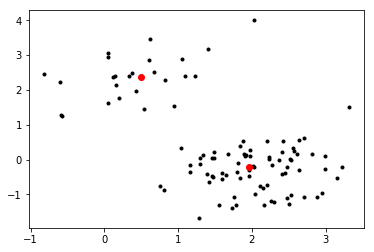

In [3]:
# Never a bad idea to visualize the dataz
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [4]:
global_params = vb.ModelParamsDict('global')

global_params.push_param(
    vb.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num))
global_params.push_param(
    vb.ArrayParam(name='mu', shape=(k_num, d_num)))
global_params.push_param(
    vb.SimplexParam(name='pi', shape=(1, k_num)))

local_params = \
    vb.SimplexParam(name='e_z', shape=(n_num, k_num),
                    val=np.full(true_z.shape, 1. / k_num))

single_local_params = \
    vb.SimplexParam(name='e_z', shape=(1, k_num), val=np.full((1, k_num), 1. / k_num))

params = vb.ModelParamsDict('mixture model')
params.push_param(global_params)
params.push_param(local_params)

true_init = False
if true_init:
    params['global']['info'].set(true_info)
    params['global']['mu'].set(true_mu)
    params['global']['pi'].set(true_pi)
else:
    params['global']['mu'].set(np.random.random(params['global']['mu'].shape()))
    

single_obs_params = vb.ModelParamsDict('mixture model single obs')
single_obs_params.push_param(params['global'])
single_obs_params.push_param(single_local_params)

init_par_vec = params.get_free()

print(params['global'])

global:
	info:
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
	mu:
[[ 0.24313251  0.20012172]
 [ 0.72277832  0.11224076]]
	pi: [[ 0.5  0.5]]


In [5]:
prior_params = vb.ModelParamsDict()
prior_params.push_param(vb.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(vb.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(vb.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(vb.ScalarParam(name='dof', val=d_num + 2.0))

In [91]:
def get_info_logdet_array(info):
    return np.array([ np.linalg.slogdet(info[k, :, :])[1] for k in range(info.shape[0]) ])

# This is the log probability of each observation for each component.
def loglik_obs_by_k(mu, info, pi, x):
    log_lik = \
        -0.5 * np.einsum('ni, kij, nj -> nk', x, info, x) + \
               np.einsum('ni, kij, kj -> nk', x, info, mu) + \
        -0.5 * np.expand_dims(np.einsum('ki, kij, kj -> k', mu, info, mu), axis=0)

    logdet_array = np.expand_dims(get_info_logdet_array(info), axis=0)
    log_pi = np.log(pi)

    log_lik += 0.5 * logdet_array + log_pi
    
    return log_lik

mu = global_params['mu'].get()
info = global_params['info'].get()
pi = global_params['pi'].get()

log_lik_array = data_log_lik_obs_by_k(mu, info, pi, x)


In [92]:
def mu_prior(mu, mu_prior_mean, mu_prior_info):
    k_num = mu.shape[0]
    d_num = len(mu_prior_mean)
    assert mu.shape[1] == d_num
    assert mu_prior_info.shape[0] == d_num
    assert mu_prior_info.shape[1] == d_num
    mu_prior_val = 0.0
    for k in range(k_num):
        mu_centered = mu[k, :] - mu_prior_mean
        mu_prior_val += -0.5 * np.matmul(np.matmul(mu_centered, mu_prior_info), mu_centered)
    return mu_prior_val
    
def pi_prior(pi, alpha):
    return np.sum(alpha * np.log(pi))

def info_prior(info, dof):
    k_num = info.shape[0]
    d_num = info.shape[1]
    assert d_num == info.shape[2]
    assert dof > d_num - 1
    # Not a complete Wishart prior
    # TODO: cache the log determinants.
    info_prior_val = 0.0
    for k in range(k_num):
        sign, logdet = np.linalg.slogdet(info[k, :, :])
        info_prior_val += 0.5 * (dof - d_num - 1) * logdet
    return info_prior_val

def multinoulli_entropy(e_z):
    return -1 * np.sum(e_z * np.log(e_z))

def get_sparse_multinoulli_entropy_hessian(e_z_vec):
    k = len(e_z_vec)
    vals = -1. / e_z_vec
    return sp.sparse.csr_matrix((vals, ((range(k)), (range(k)))), (k, k))

weights = np.full((n_num, 1), 1.0)
e_z = params['e_z'].get()
data_log_likelihood(true_mu, true_info, e_z, pi, x)
mu_prior(true_mu, mu_prior_mean, mu_prior_info)
pi_prior(true_pi, 2.0)
info_prior(true_info, d_num + 2)
multinoulli_entropy(e_z)

get_multinoulli_entropy_hessian = autograd.hessian(multinoulli_entropy)
e_z0 = e_z[0, :]

print(np.max(np.abs(
    get_multinoulli_entropy_hessian(e_z0) - get_sparse_multinoulli_entropy_hessian(e_z0).toarray())))

0.0


In [129]:
from VariationalBayes.Parameters import convert_vector_to_free_hessian

class Objective(object):
    def __init__(self, x, params, prior_params):
        self.x = x
        self.params = deepcopy(params)
        self.prior_params = deepcopy(prior_params)
        self.weights = np.full((x.shape[0], 1), 1.0)

        # Autograd derivatives
        self.kl_free_grad = autograd.grad(self.kl_free)
        self.kl_free_hessian = autograd.hessian(self.kl_free) # This will be slow.
        self.kl_free_hvp = autograd.hessian_vector_product(self.kl_free)

        self.kl_free_global_grad = autograd.grad(self.kl_free_global)
        self.kl_free_global_hessian = autograd.hessian(self.kl_free_global)
        self.kl_free_global_hvp = autograd.hessian_vector_product(self.kl_free_global)

        self.get_z_nat_params = autograd.grad(self.loglik_e_z)

        self.get_moment_jacobian = autograd.jacobian(self.get_interesting_moments)
        
        self.kl_vector_global_jac = autograd.jacobian(self.kl_vector_global_local, argnum=0)
        self.kl_vector_global_hessian = autograd.hessian(self.kl_vector_global_local, argnum=0)
        self.kl_vector_global_local_hessian = autograd.jacobian(self.kl_vector_global_jac, argnum=1)

        self.kl_vector_jac = autograd.jacobian(self.kl_vector)
        self.kl_vector_hessian = autograd.hessian(self.kl_vector)

    def loglik_obs_by_k(self):
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()        
        return loglik_obs_by_k(mu, info, pi, self.x)

    # This needs to be defined so we can differentiate it for CAVI.
    def loglik_e_z(self, e_z):
        return np.sum(e_z * self.loglik_obs_by_k())

    def loglik(self):
        e_z = self.params['e_z'].get()
        return self.loglik_e_z(e_z)

    def loglik_obs(self):
        log_lik_array = self.loglik_obs_by_k()
        e_z = self.params['e_z'].get()
        return np.sum(log_lik_array * e_z, axis=1)    

    def prior(self):
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()        
        mu_prior_mean = self.prior_params['mu_prior_mean'].get()
        mu_prior_info = self.prior_params['mu_prior_info'].get()
        prior = 0.
        prior += mu_prior(mu, mu_prior_mean, mu_prior_info)
        prior += pi_prior(pi, self.prior_params['alpha'].get())
        prior += info_prior(info, self.prior_params['dof'].get())
        return prior
    
    def optimize_z(self):
        # Take a CAVI step on Z.
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()
        e_z = self.params['e_z'].get()

        natural_parameters = obj.get_z_nat_params(e_z)
        z_logsumexp = np.expand_dims(sp.misc.logsumexp(natural_parameters, 1), axis=1)
        e_z = np.exp(natural_parameters - z_logsumexp)
        self.params['e_z'].set(e_z)
    
    def kl(self, include_local_entropy=True):
        elbo = self.prior() + self.loglik()

        if include_local_entropy:
            e_z = self.params['e_z'].get()
            elbo += multinoulli_entropy(e_z)
        
        return -1 * elbo
    

    #######################
    # Moments for sensitivity
    
    def get_interesting_moments(self, free_params):
        self.params.set_free(free_params)
        return self.params['global']['mu'].get_vector()

    ######################################
    # Compute sparse hessians by hand.

    # Log likelihood by data point.
    
    # The rows are the z vector indices and the columns are the data points.
    def loglik_vector_local_weight_hessian_sparse(self):
        log_lik_array = self.loglik_obs_by_k()

        hess_vals = [] # These will be the entries of dkl / dz dweight^T
        hess_rows = [] # These will be the z indices
        hess_cols = [] # These will be the data indices
        # This is the Hessian of the negative entropy, which enters the KL divergence.
        for row in range(e_z.shape[0]):
            z_row_inds = self.params['e_z'].get_vector_indices(row)
            for col in range(e_z.shape[1]):
                hess_vals.append(log_lik_array[row, col])
                hess_rows.append(z_row_inds[col])
                hess_cols.append(row)

        local_size = self.params['e_z'].vector_size()
        return sp.sparse.csr_matrix((hess_vals, (hess_rows, hess_cols)),
                                     (local_size, self.x.shape[0]))

    def loglik_free_local_weight_hessian_sparse(self):
        free_par_local = self.params['e_z'].get_free()
        free_to_vec_jac = self.params['e_z'].free_to_vector_jac(free_par_local) 
        return free_to_vec_jac .T * \
               self.loglik_vector_local_weight_hessian_sparse()
        
    def loglik_free_weight_hessian_sparse(self):
        self.loglik_obs_free_global_jac = \
            autograd.jacobian(self.loglik_obs_free_global_local, argnum=0)
        loglik_obs_free_global_jac = \
            self.loglik_obs_free_global_jac(self.params['global'].get_free(),
                                            self.params['e_z'].get_free())
        loglik_obs_free_local_jac = \
            self.loglik_free_local_weight_hessian_sparse()
        return sp.sparse.vstack([loglik_obs_free_global_jac, loglik_obs_free_local_jac])

    # KL
    def kl_vector_local_hessian_sparse(self):
        e_z = self.params['e_z'].get()
        hess_vals = []
        hess_rows = []
        # This is the Hessian of the negative entropy, which enters the KL divergence.
        for row in range(e_z.shape[0]):
            row_inds = self.params['e_z'].get_vector_indices(row)
            for col in range(e_z.shape[1]):
                hess_vals.append(1. / e_z[row, col])
                hess_rows.append(row_inds[col])
        local_size = self.params['e_z'].vector_size()
        return sp.sparse.csr_matrix((hess_vals, (hess_rows, hess_rows)),
                                    (local_size, local_size))

    def kl_vector_hessian_sparse(self):
        global_vec = obj.params['global'].get_vector()
        local_vec = obj.params['e_z'].get_vector()
    
        global_hess = obj.kl_vector_global_hessian(global_vec, local_vec)
        global_local_hess = obj.kl_vector_global_local_hessian(global_vec, local_vec)
        local_hess_sparse = self.kl_vector_local_hessian_sparse()
        sp_hess =  sp.sparse.bmat([ [global_hess,         global_local_hess],
                                    [global_local_hess.T, local_hess_sparse]])
        return np.array(sp_hess.toarray())
    

    # This takes free_params as an argument so it can be used in optimization.
    def kl_free_hessian_sparse(self, free_params):
        self.params.set_free(free_params)
        kl_vector_hessian_sparse = self.kl_vector_hessian_sparse()
        kl_vector_jac = self.kl_vector_jac(vec_par)
        kl_hessian_sparse = convert_vector_to_free_hessian(
            self.params, free_params, kl_vector_jac, kl_vector_hessian_sparse)

        # If you don't convert to an array, it returns a matrix type, which
        # seems to cause mysterious problems with scipy.optimize.minimize.
        return np.array(kl_hessian_sparse)

    ##################################
    # Wrappers for autodiff follow. The nomeclature is
    # {function}_{free | vector}_{|global|local}_{|sparse}

    def kl_free(self, free_params, verbose=False):
        self.params.set_free(free_params)
        kl = self.kl()
        if verbose:
            print(kl)
        return kl

    def kl_free_global(self, global_free_params, verbose=False):
        self.params['global'].set_free(global_free_params)
        kl = self.kl(include_local_entropy=False)
        if verbose:
            print(kl)
        return kl

    def kl_vector_global_local(self, global_vec_params, local_vec_params,
                               verbose=False, include_local_entropy=True):
        self.params['global'].set_vector(global_vec_params)
        self.params['e_z'].set_vector(local_vec_params)
        kl = self.kl(include_local_entropy=include_local_entropy)
        if verbose:
            print(kl)
        return kl

    def kl_vector(self, vec_params, 
                  verbose=False, include_local_entropy=True):
        self.params.set_vector(vec_params)
        kl = self.kl(include_local_entropy=include_local_entropy)
        if verbose:
            print(kl)
        return kl
    
    def loglik_obs_free_global_local(self, free_params_global, free_params_local):
        self.params['global'].set_free(free_params_global)
        self.params['e_z'].set_free(free_params_local)
        return self.loglik_obs()


In [131]:
obj = Objective(x, params, prior_params)
obj.optimize_z()

free_par = params.get_free()
vec_par = params.get_vector()

global_free_par = params['global'].get_free()
obj.kl_free(free_par)

grad = obj.kl_free_grad(free_par)

hvp_time = time.time()
hvp = obj.kl_free_hvp(free_par, grad)
hvp_time = time.time() - hvp_time

grad = obj.kl_free_global_grad(global_free_par)
hvp = obj.kl_free_global_hvp(global_free_par, grad)

# Not as slow!  You can ignore the autograd warning.
sparse_hess_time = time.time()
sparse_hessian = obj.kl_free_hessian_sparse(free_par)
sparse_hess_time = time.time() - sparse_hess_time

print('Hessian: ', sparse_hess_time)
print('Hessian vector product', hvp_time)

Hessian:  0.4117100238800049
Hessian vector product 0.020519733428955078


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [132]:
# Check the weight Jacobians.
get_loglik_obs_free_local_jac = \
    autograd.jacobian(obj.loglik_obs_free_global_local, argnum=1)

free_par_global = obj.params['global'].get_free()
free_par_local = obj.params['e_z'].get_free()


loglik_obs_free_local_jac = \
    get_loglik_obs_free_local_jac(free_par_global, free_par_local)

loglik_vector_local_weight_hessian_sparse = \
    obj.loglik_vector_local_weight_hessian_sparse()

likelihood_by_obs_free_local_jac_sparse = \
    obj.loglik_free_local_weight_hessian_sparse()

print(obj.x.shape)
print(likelihood_by_obs_free_local_jac_sparse.shape)
print(loglik_vector_local_weight_hessian_sparse.shape)
print(np.max(np.abs(loglik_obs_free_local_jac - likelihood_by_obs_free_local_jac_sparse)))


(100, 2)
(100, 100)
(200, 100)
4.4408920985e-16


In [133]:
obj.loglik_free_weight_hessian_sparse()

TypeError: loglik_obs_free_global_local() missing 1 required positional argument: 'free_params_local'

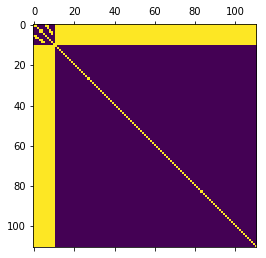

In [128]:
if True:
    # Compare the full and sparse Hessians
    kl_vector_hessian = autograd.hessian(obj.kl_vector)
    hessian = obj.kl_free_hessian(free_par) # Slow
    vector_hessian = kl_vector_hessian(vec_par)  # Slow

    # The slow full Hessian and sparse Hessian agree.
    plt.matshow(sparse_hessian != 0)
    assert np.max(np.abs(hessian - sparse_hessian)) < 1e-8


In [ ]:
if False:
    import cProfile, pstats
    from scipy.sparse import csr_matrix

    param = obj.params
    free_val = free_par

    #cProfile.run('obj.get_sparse_hessian(free_par)', 'prof_hess')
    cProfile.run('param.free_to_vector_hess(free_val)', 'prof_hess')

    param.set_free(free_val)
    vec_par = param.get_vector()

    print('0')
    tic = time.time()
    vector_hess = obj.get_sparse_vector_hessian(vec_par)
    print(time.time() - tic)

    print('1')
    tic = time.time()
    vector_jac = obj.get_vector_jacobian(vec_par)
    print(time.time() - tic)

    print('2')
    tic = time.time()
    vector_jac = obj.get_vector_jacobian(vec_par)
    print(time.time() - tic)

    print('3')
    tic = time.time()
    free_hess = csr_matrix((param.free_size(), param.free_size()))
    print(time.time() - tic)

    print('4')
    tic = time.time()
    free_to_vec_jacobian = param.free_to_vector_jac(free_val)
    print(time.time() - tic)

    print('5')
    tic = time.time()
    free_to_vec_hessian = param.free_to_vector_hess(free_val)
    print(time.time() - tic)

    # Accumulate the third order terms, which are sparse.
    print('6')
    tic = time.time()
    for vec_ind in range(param.vector_size()):
        free_hess += free_to_vec_hessian[vec_ind] * vector_jac[vec_ind]
    print(time.time() - tic)

    # Then add the second-order terms, which may be dense depending on the
    # vec_hess_target.
    print('7')
    tic = time.time()
    free_hess += \
        free_to_vec_jacobian.T * vector_hess * free_to_vec_jacobian
    print(time.time() - tic)


    import pstats
    prof_hess = pstats.Stats('prof_hess')
    prof_hess.strip_dirs().sort_stats('cumulative').print_stats()


In [43]:
# Perform EM.

obj.params.set_free(init_par_vec)
obj.optimize_z()
global_param_vec = obj.params['global'].get_vector()
kl = obj.kl()

for step in range(20):
    global_free_par = obj.params['global'].get_free()

    # Different choices for the M step:
    global_vb_opt = optimize.minimize(
       lambda par: obj.kl_free_global(par, verbose=False),
       x0=global_free_par, jac=obj.kl_free_global_grad, hessp=obj.kl_free_global_hvp,
       method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-2})
    #global_vb_opt = optimize.minimize(
    #    lambda par: obj.global_kl_wrapper(par, verbose=False),
    #    x0=global_free_par, jac=obj.global_kl_grad, hess=obj.global_kl_hessian,
    #    method='trust-ncg', options={'maxiter': 50})
    #global_vb_opt = optimize.minimize(
    #   lambda par: obj.global_kl_wrapper(par, verbose=False),
    #   x0=global_free_par, method='nelder-mead', options={'maxiter': 500})
    #global_vb_opt = optimize.minimize(
    #   lambda par: obj.global_kl_wrapper(par, verbose=False),
    #  x0=global_free_par, method='bfgs', options={'maxiter': 50})
    obj.params['global'].set_free(global_vb_opt.x)

    # E-step:
    obj.optimize_z()

    new_global_param_vec = obj.params['global'].get_vector()
    diff = np.max(np.abs(new_global_param_vec - global_param_vec))
    global_param_vec = deepcopy(new_global_param_vec)
    
    new_kl = obj.kl()
    kl_diff = new_kl - kl
    kl = new_kl
    print(' kl: {}\t\tkl_diff = {}\t\tdiff = {}'.format(kl, kl_diff, diff))
    if diff < 1e-6:
        break

em_free_par = obj.params.get_free()
print('Done.')


 kl: 99.36596941834514		kl_diff = -99.00005454383555		diff = 1.1063302705533213
 kl: 97.07326486316953		kl_diff = -2.292704555175618		diff = 0.14819079070311614
 kl: 91.0344650304055		kl_diff = -6.0387998327640275		diff = 0.24128875688728924
 kl: 77.53292718150888		kl_diff = -13.501537848896618		diff = 0.6655026873373024
 kl: 68.79290516026671		kl_diff = -8.740022021242169		diff = 1.1626734188434344
 kl: 67.02971871769243		kl_diff = -1.7631864425742805		diff = 0.2036538004938695
 kl: 65.1712618933191		kl_diff = -1.8584568243733344		diff = 0.17864512356269246
 kl: 62.47244409632887		kl_diff = -2.6988177969902267		diff = 0.201972737773096
 kl: 58.25291238310025		kl_diff = -4.219531713228619		diff = 0.455598326989211
 kl: 52.78292417231202		kl_diff = -5.46998821078823		diff = 0.968638523186081
 kl: 51.4830960986777		kl_diff = -1.2998280736343233		diff = 1.017606220383827
 kl: 51.48266270556726		kl_diff = -0.00043339311044121587		diff = 0.02023628969841429
 kl: 51.48266248498899		kl_diff =

In [44]:
# Finish with one joint Newton optimization to ensure global optimality.
vb_opt = optimize.minimize(
    lambda par: obj.kl_free(par, verbose=True),
    x0=em_free_par, jac=obj.kl_free_grad, hessp=obj.kl_free_hvp,
    method='trust-ncg', options={'maxiter': 50})

print('Done')
obj.params.set_free(vb_opt.x)

51.4826624841
51.4826624841
Done


In [47]:
if False:
    # This isn't any faster, though with the sparse Hessian it's at least now comparable.
    vb_opt_hess = optimize.minimize(
        lambda par: obj.kl_free(par, verbose=True),
        x0=em_free_par, jac=obj.kl_free_grad, hess=obj.kl_free_hessian_sparse,
        method='trust-ncg', options={'maxiter': 50})

    print('done')
    print(obj.kl_free(vb_opt_hess.x))

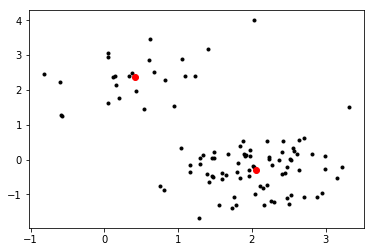

In [48]:
# Check that the solution looks sensible.
mu_fit = obj.params['global']['mu'].get()
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(mu_fit[k, 0], mu_fit[k, 1], 'ro')

In [52]:
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix

moment_jac = obj.get_moment_jacobian(vb_opt.x)

# use_cg = False
# if use_cg:
#     # Get the sensitivity operator with conjugate gradient to avoid constructing the Hessian.
#     # This was necessary before we had the sparse Hessian.
#     sensitivity_operator = np.full_like(moment_jac, float('nan'))
#     free_param_size = len(vb_opt.x)

#     KLHessVecProdLO = LinearOperator((free_param_size, free_param_size),
#                                      lambda vec: obj.kl_hvp(vb_opt.x, vec))
#     for ind in range(sensitivity_operator.shape[0]):
#         cg_res, info = sp.sparse.linalg.cg(KLHessVecProdLO, moment_jac[ind, :].T)
#         sensitivity_operator[ind, :] = cg_res

kl_free_hessian_sparse = obj.kl_free_hessian_sparse(vb_opt.x)
sensitivity_operator = sp.sparse.linalg.spsolve(csc_matrix(kl_free_hessian_sparse), csr_matrix(moment_jac).T)


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


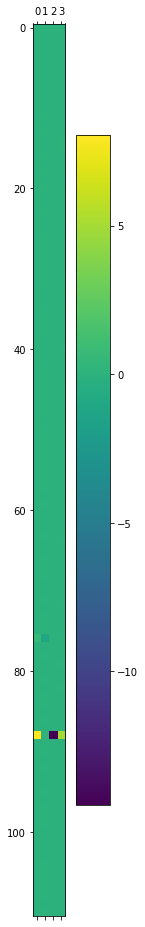

In [53]:
plt.matshow(sensitivity_operator.toarray())
plt.colorbar()

In [ ]:
obj.params.set_free(vb_opt.x)
def kl_weight_fun(weights):
    obj.weights = weights
    return obj.kl()

default_weights = np.full((n_num, 1), 1.0)
get_kl_weight_grad = autograd.grad(kl_weight_fun)
kl_weight_grad = get_kl_weight_grad(default_weights)
mu_weight_sens = np.matmul(sensitivity_operator, kl_weight_grad)